In [1]:
import math 
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite
import networkx as nx
from ortools.linear_solver import pywraplp as OR
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
import pickle
from bokeh import palettes
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import (GraphRenderer, Circle, MultiLine, StaticLayoutProvider,
                          HoverTool, TapTool, EdgesAndLinkedNodes, NodesAndLinkedEdges,
                          ColumnDataSource, LabelSet, NodesOnly)
from bokeh.models.markers import Triangle
from bokeh.io import export_png
output_notebook()

Loading BokehJS ...

In [2]:
trips_df = pd.read_csv('data/2013-09-01_trip_data_manhattan.csv').drop(columns='id')
nodes_df = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs_df = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')
# A dictionary with dropoff-pickup pairs as keys and travel times as values - generated from another notebook
with open('data/time_map.pkl', 'rb') as f:
    times = pickle.load(f)

### Find a sample subset of trips

In [3]:
# filter trips by time window of interest
start_time = 1020
end_time = 1035
trips = trips_df.copy()
trips = trips[(trips.start_time >= start_time) & 
              (trips.start_time + trips.trip_time <= end_time)].copy()
trips.start_time = trips.start_time - start_time

# Intialize nodes and edges
DO_nodes = list()
PU_nodes = list()
edges = list()
# Initialize a dict that maps a PU node to a DO node
PUtoDO = dict()

# Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
for index, row in trips.iterrows():
    s = row['start_node']
    t = row['end_node']
    s_t = row['start_time']
    t_t = s_t + row['trip_time']
    DO_node = (int(t), t_t, index, 'DO')
    PU_node = (int(s), s_t, index, 'PU')
    DO_nodes.append(DO_node)
    PU_nodes.append(PU_node)
    PUtoDO[PU_node] = DO_node

# Sort the nodes by time
DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
PU_nodes = sorted(PU_nodes, key = lambda x: x[1])

# Specify edges
max_waiting_time = 5

for DO_node in DO_nodes:
    for PU_node in PU_nodes:
        if PU_node[1] > DO_node[1] + max_waiting_time:
            break
        else:
            if PU_node[1] >= DO_node[1]:
                time = times[(DO_node[0], PU_node[0])]
                if ((PU_node[1] - DO_node[1]) - max_waiting_time  <= time) & (time <= (PU_node[1] - DO_node[1])):
                    edges.append((DO_node, PU_node))

# load the model
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(DO_nodes, bipartite=0)
B.add_nodes_from(PU_nodes, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(edges)

top_nodes = {n for n, d in B.nodes(data = True) if d["bipartite"] == 0}

match = nx.bipartite.maximum_matching(B, DO_nodes)

[82016, 81855, 81152, 81247, 81954, 82007, 81114, 82250, 81090]

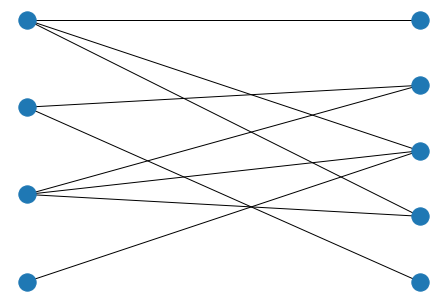

In [4]:
c= [c for c in sorted(nx.connected_components(B), key=len, reverse=True)][1]
largest_B = B.subgraph(c).copy()
top_nodes = {n for n, d in largest_B.nodes(data = True) if d["bipartite"] == 0}
pos = nx.bipartite_layout(largest_B, top_nodes, scale = 2)
nx.draw(largest_B, pos=pos)
[node[2] for node in largest_B.nodes]

In [5]:
ex_trips = [81247, 82007, 81152, 81954, 82250,  81855, 81114, 81090, 82851, 82629]

In [6]:
trips = trips_df.iloc[ex_trips]

# Intialize nodes and edges
DO_nodes = list()
PU_nodes = list()
edges = list()
# Initialize a dict that maps a PU node to a DO node
PUtoDO = dict()

# Specify nodes - each node is a tuple of (location_id, time, trip_id, "DO"/"PU")
for index, row in trips.iterrows():
    s = row['start_node']
    t = row['end_node']
    s_t = row['start_time']
    t_t = s_t + row['trip_time']
    DO_node = (int(t), t_t, index, 'DO')
    PU_node = (int(s), s_t, index, 'PU')
    DO_nodes.append(DO_node)
    PU_nodes.append(PU_node)
    PUtoDO[PU_node] = DO_node

# Sort the nodes by time
DO_nodes = sorted(DO_nodes, key = lambda x: x[1])
PU_nodes = sorted(PU_nodes, key = lambda x: x[1])

# Specify edges
max_waiting_time = 10

for DO_node in DO_nodes:
    for PU_node in PU_nodes:
        if PU_node[1] > DO_node[1] + max_waiting_time:
            break
        else:
            if PU_node[1] >= DO_node[1]:
                time = times[(DO_node[0], PU_node[0])]
                if ((PU_node[1] - DO_node[1]) - max_waiting_time  <= time) & (time <= (PU_node[1] - DO_node[1])):
                    edges.append((DO_node, PU_node))

# load the model
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(DO_nodes, bipartite=0)
B.add_nodes_from(PU_nodes, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(edges)

top_nodes = {n for n, d in B.nodes(data = True) if d["bipartite"] == 0}

match = nx.bipartite.maximum_matching(B, DO_nodes)
unmatch_PU = list(set(PU_nodes) - set(match.keys()))
unmatch_DO = list(set(DO_nodes) - set(match.keys()))

In [7]:
match

{(581, 1023.0, 81090, 'DO'): (46, 1027.0, 81855, 'PU'),
 (1314, 1023.0, 81247, 'DO'): (1312, 1028.0, 82007, 'PU'),
 (752, 1030.0, 81954, 'DO'): (751, 1033.0, 82629, 'PU'),
 (305, 1024.0, 81114, 'DO'): (889, 1028.0, 81954, 'PU'),
 (1312, 1026.0, 81152, 'DO'): (581, 1030.0, 82250, 'PU'),
 (1796, 1033.0, 81855, 'DO'): (1796, 1035.0, 82851, 'PU'),
 (1312, 1028.0, 82007, 'PU'): (1314, 1023.0, 81247, 'DO'),
 (751, 1033.0, 82629, 'PU'): (752, 1030.0, 81954, 'DO'),
 (889, 1028.0, 81954, 'PU'): (305, 1024.0, 81114, 'DO'),
 (581, 1030.0, 82250, 'PU'): (1312, 1026.0, 81152, 'DO'),
 (1796, 1035.0, 82851, 'PU'): (1796, 1033.0, 81855, 'DO'),
 (46, 1027.0, 81855, 'PU'): (581, 1023.0, 81090, 'DO')}

In [8]:
# Sort the nodes by trip_id
DO_nodes = sorted(DO_nodes, key = lambda x: x[2], reverse = True)
PU_nodes = sorted(PU_nodes, key = lambda x: x[2], reverse = True)

In [9]:
B.edges

EdgeView([((1314, 1023.0, 81247, 'DO'), (1312, 1028.0, 82007, 'PU')), ((1314, 1023.0, 81247, 'DO'), (581, 1030.0, 82250, 'PU')), ((581, 1023.0, 81090, 'DO'), (46, 1027.0, 81855, 'PU')), ((581, 1023.0, 81090, 'DO'), (1312, 1028.0, 82007, 'PU')), ((581, 1023.0, 81090, 'DO'), (889, 1028.0, 81954, 'PU')), ((581, 1023.0, 81090, 'DO'), (581, 1030.0, 82250, 'PU')), ((305, 1024.0, 81114, 'DO'), (889, 1028.0, 81954, 'PU')), ((305, 1024.0, 81114, 'DO'), (751, 1033.0, 82629, 'PU')), ((1312, 1026.0, 81152, 'DO'), (46, 1027.0, 81855, 'PU')), ((1312, 1026.0, 81152, 'DO'), (1312, 1028.0, 82007, 'PU')), ((1312, 1026.0, 81152, 'DO'), (581, 1030.0, 82250, 'PU')), ((752, 1030.0, 81954, 'DO'), (751, 1033.0, 82629, 'PU')), ((1796, 1033.0, 81855, 'DO'), (1796, 1035.0, 82851, 'PU'))])

In [10]:
match.items()

dict_items([((581, 1023.0, 81090, 'DO'), (46, 1027.0, 81855, 'PU')), ((1314, 1023.0, 81247, 'DO'), (1312, 1028.0, 82007, 'PU')), ((752, 1030.0, 81954, 'DO'), (751, 1033.0, 82629, 'PU')), ((305, 1024.0, 81114, 'DO'), (889, 1028.0, 81954, 'PU')), ((1312, 1026.0, 81152, 'DO'), (581, 1030.0, 82250, 'PU')), ((1796, 1033.0, 81855, 'DO'), (1796, 1035.0, 82851, 'PU')), ((1312, 1028.0, 82007, 'PU'), (1314, 1023.0, 81247, 'DO')), ((751, 1033.0, 82629, 'PU'), (752, 1030.0, 81954, 'DO')), ((889, 1028.0, 81954, 'PU'), (305, 1024.0, 81114, 'DO')), ((581, 1030.0, 82250, 'PU'), (1312, 1026.0, 81152, 'DO')), ((1796, 1035.0, 82851, 'PU'), (1796, 1033.0, 81855, 'DO')), ((46, 1027.0, 81855, 'PU'), (581, 1023.0, 81090, 'DO'))])

In [11]:
nx.bipartite.to_vertex_cover(B, match, top_nodes)

{(305, 1024.0, 81114, 'DO'),
 (581, 1023.0, 81090, 'DO'),
 (752, 1030.0, 81954, 'DO'),
 (1312, 1026.0, 81152, 'DO'),
 (1314, 1023.0, 81247, 'DO'),
 (1796, 1033.0, 81855, 'DO')}

In [13]:
# track the paths of the taxis
opt_paths = []
for PU_node in unmatch_PU:
    path = []
    # Find the drop-off node corresponding to the first unmatched pick-up node
    next_node = PUtoDO[PU_node]
    path.append((PU_node, next_node, True))
    while next_node in match.keys():
        if next_node[-1] == 'PU':
            cur_node = copy.deepcopy(next_node)
            next_node = PUtoDO[cur_node]
            path.append((cur_node, next_node, True))
        else:
            cur_node = copy.deepcopy(next_node)
            next_node = match[cur_node]
            path.append((cur_node, next_node, False))
    opt_paths.append(path)

In [14]:
opt_paths

[[((586, 1020.0, 81090, 'PU'), (581, 1023.0, 81090, 'DO'), True),
  ((581, 1023.0, 81090, 'DO'), (46, 1027.0, 81855, 'PU'), False),
  ((46, 1027.0, 81855, 'PU'), (1796, 1033.0, 81855, 'DO'), True),
  ((1796, 1033.0, 81855, 'DO'), (1796, 1035.0, 82851, 'PU'), False),
  ((1796, 1035.0, 82851, 'PU'), (480, 1039.0, 82851, 'DO'), True)],
 [((2588, 1021.0, 81247, 'PU'), (1314, 1023.0, 81247, 'DO'), True),
  ((1314, 1023.0, 81247, 'DO'), (1312, 1028.0, 82007, 'PU'), False),
  ((1312, 1028.0, 82007, 'PU'), (158, 1035.0, 82007, 'DO'), True)],
 [((2010, 1020.0, 81152, 'PU'), (1312, 1026.0, 81152, 'DO'), True),
  ((1312, 1026.0, 81152, 'DO'), (581, 1030.0, 82250, 'PU'), False),
  ((581, 1030.0, 82250, 'PU'), (1597, 1034.0, 82250, 'DO'), True)],
 [((590, 1020.0, 81114, 'PU'), (305, 1024.0, 81114, 'DO'), True),
  ((305, 1024.0, 81114, 'DO'), (889, 1028.0, 81954, 'PU'), False),
  ((889, 1028.0, 81954, 'PU'), (752, 1030.0, 81954, 'DO'), True),
  ((752, 1030.0, 81954, 'DO'), (751, 1033.0, 82629, 'PU')

In [34]:
# Edge colored in red if it belongs to the max card matching
edge_color = []
for edge in B.edges:
    if (edge[0], edge[1]) in match.items():
        edge_color.append('tab:red')
    else:
        edge_color.append('black')
# Decide node colors based on the correspong paths
color_map = []
colors = palettes.Plasma[len(opt_paths)]
for node in B:
    for i in range(len(opt_paths)):
        if node in list(zip(*opt_paths[i]))[0] + list(zip(*opt_paths[i]))[1]:
            color_map.append(colors[i])

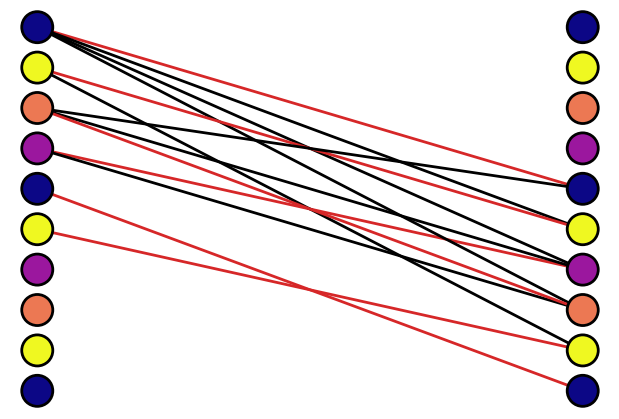

In [35]:
plt.figure(figsize=(6, 4), dpi = 100)

# Update node position so that the drop-off node corresponds to the pickup node
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(DO_nodes)) 
pos.update((n, (2, i)) for i, n in enumerate(PU_nodes)) 

nx.draw(B, pos=pos, with_labels = False, node_size = 500,  node_color = color_map, edge_color = edge_color, width = 2, linewidths = 2, edgecolors = 'black')
plt.show()

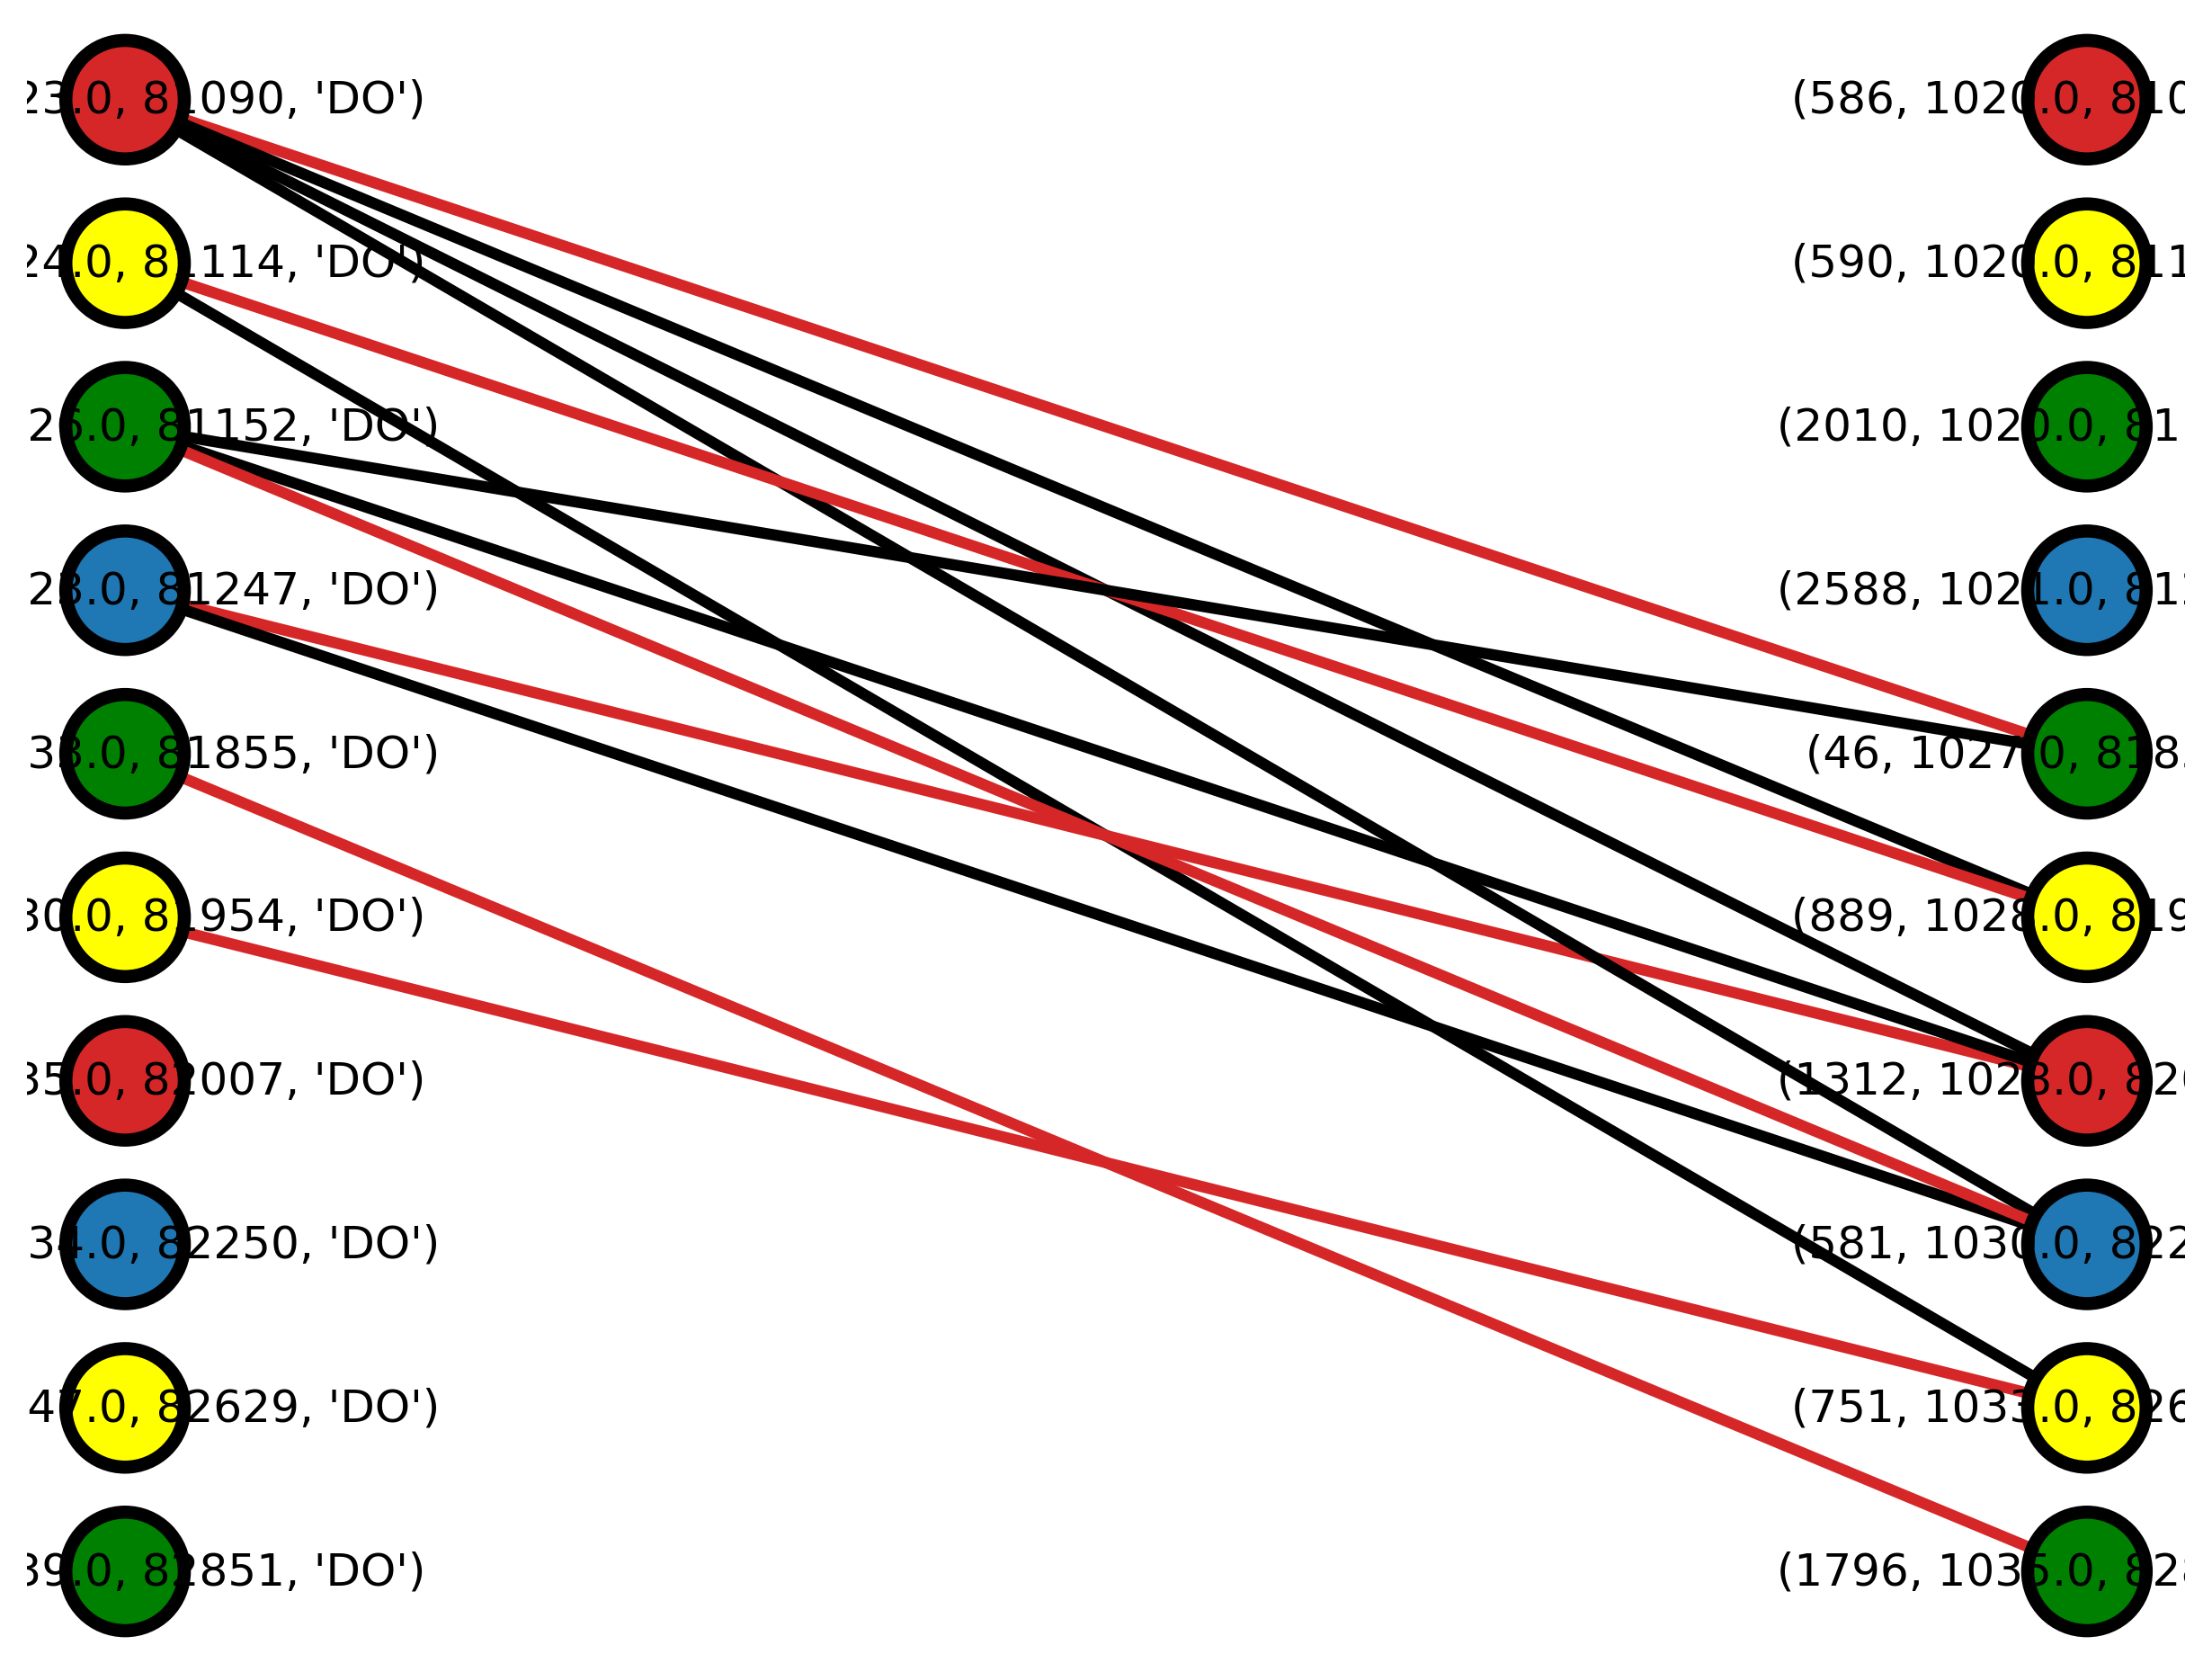

In [25]:
plt.figure(figsize=(8, 6), dpi=300)

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(DO_nodes) ) # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(PU_nodes) ) # put nodes from Y at x=2

node_color = ['tab:blue', 'tab:red', 'yellow', 'green', 'yellow', 'green','tab:blue','tab:red','green','yellow','green',
              'yellow', 'tab:red','tab:blue', 'green','tab:red','yellow','tab:blue', 'yellow','green']
nx.draw(B, pos=pos, with_labels = True, node_size = 1000,  node_color = node_color, edge_color = edge_color, width = 3, linewidths = 3.5, edgecolors = 'black')
# plt.savefig('visuals/ex_bipartite.png', dpi = 1000)
plt.show()

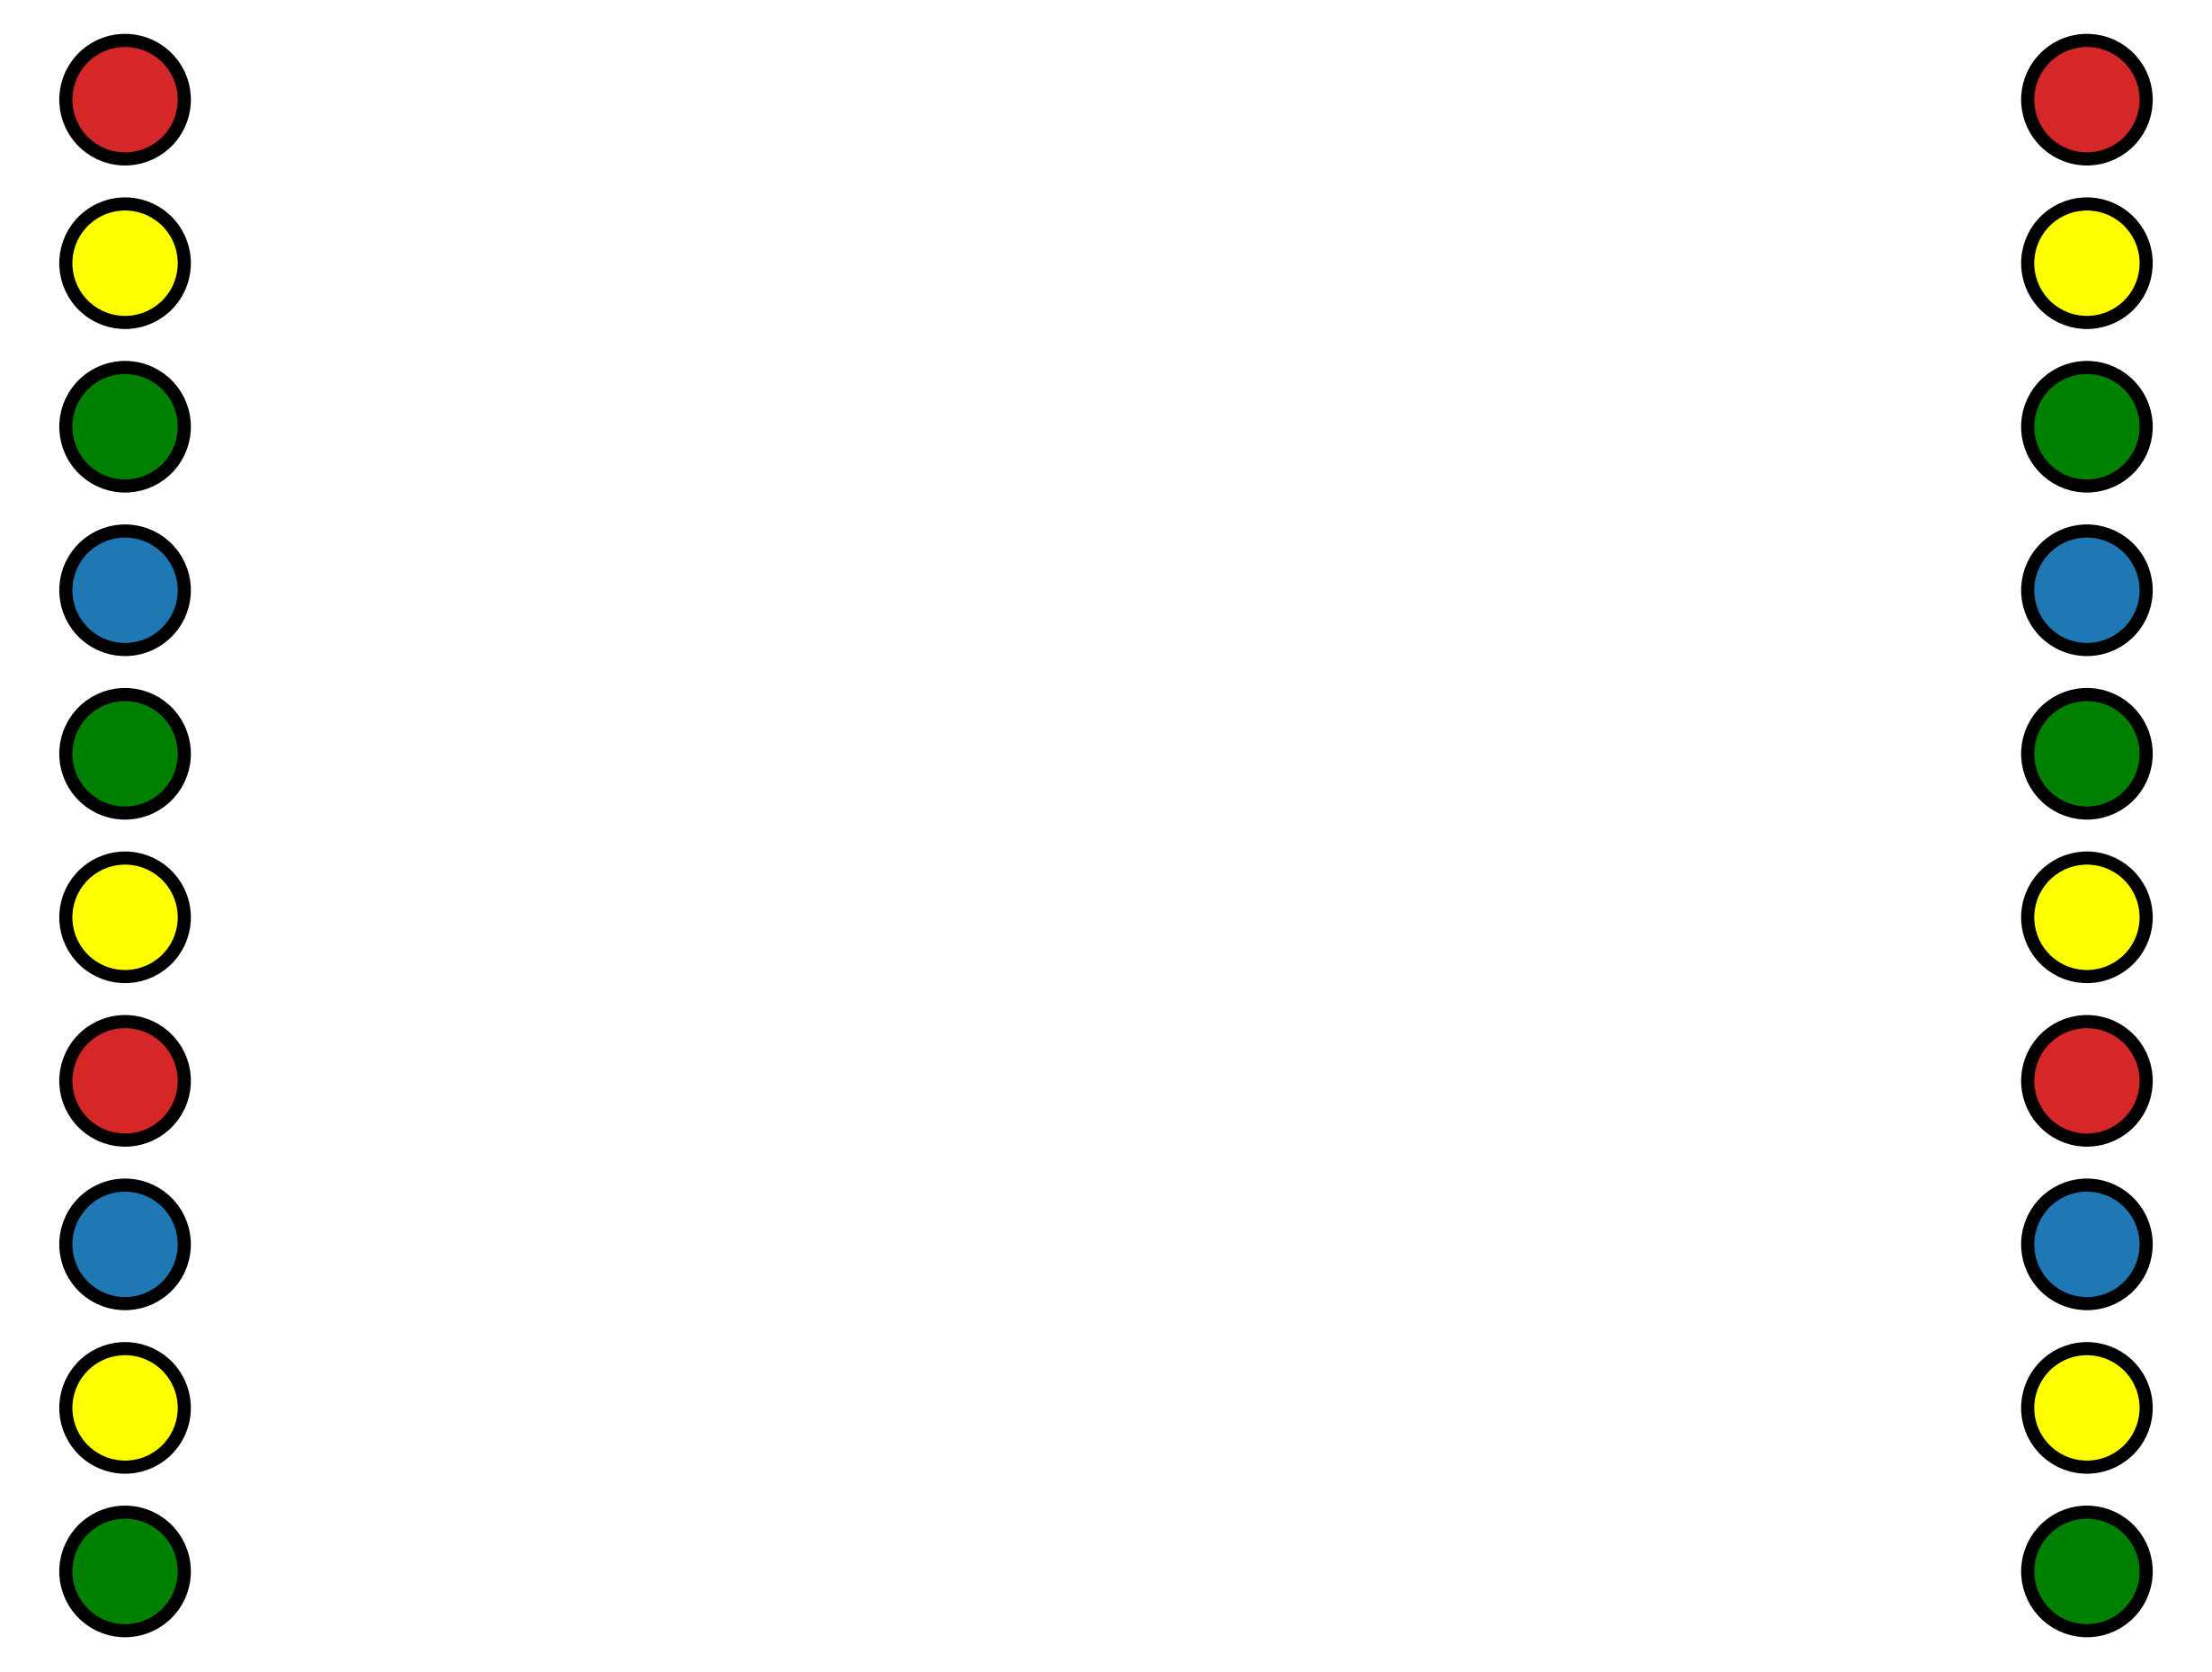

In [22]:
plt.figure(figsize=(8, 6), dpi=300)

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(DO_nodes) ) # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(PU_nodes) ) # put nodes from Y at x=2

node_color = ['tab:blue', 'tab:red', 'yellow', 'green', 'yellow', 'green','tab:blue','tab:red','green','yellow','green',
              'yellow', 'tab:red','tab:blue', 'green','tab:red','yellow','tab:blue', 'yellow','green']
nx.draw(B, pos=pos, with_labels = False, node_size = 1000,  node_color = node_color, edge_color = 'white', width = 3, linewidths = 3.5, edgecolors = 'black')
plt.savefig('visuals/ex_bipartite_nodes.png', dpi = 1000)
plt.show()

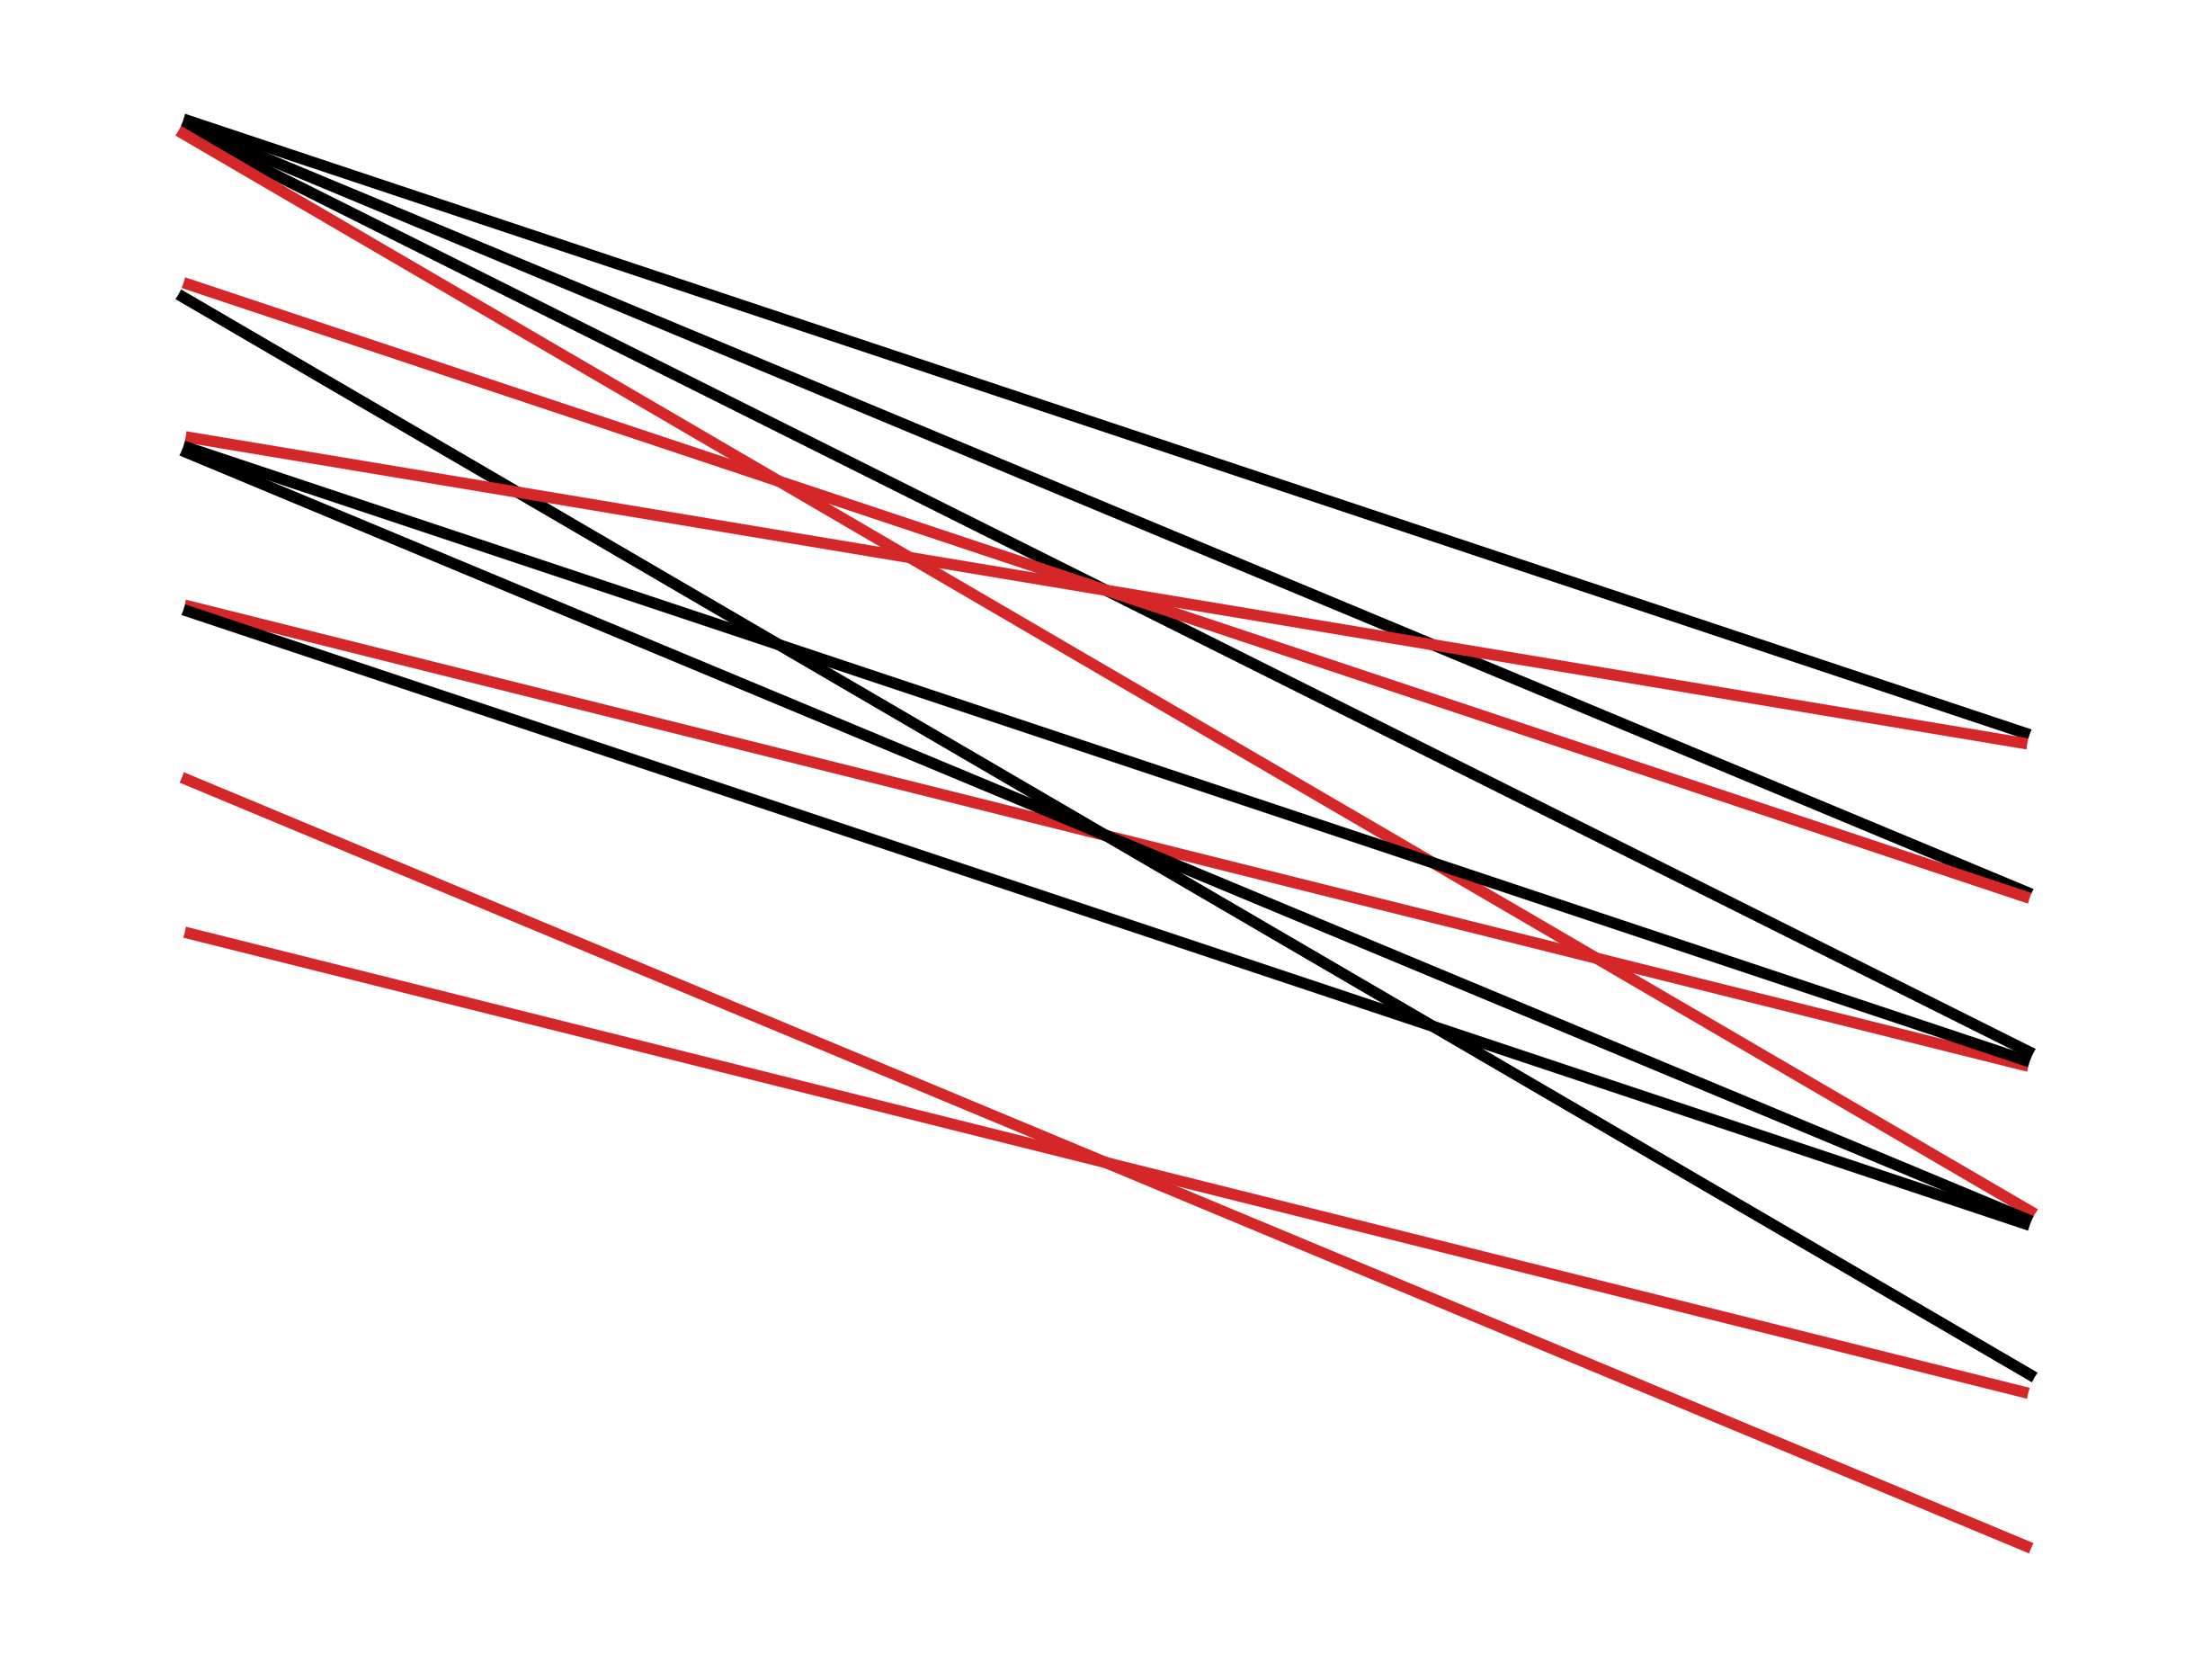

In [24]:
plt.figure(figsize=(8, 6), dpi=300)

pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(DO_nodes) ) # put nodes from X at x=1
pos.update((n, (2, i)) for i, n in enumerate(PU_nodes) ) # put nodes from Y at x=2

node_color = ['tab:blue', 'tab:red', 'yellow', 'green', 'yellow', 'green','tab:blue','tab:red','green','yellow','green',
              'yellow', 'tab:red','tab:blue', 'green','tab:red','yellow','tab:blue', 'yellow','green']
nx.draw(B, pos=pos, with_labels = False, node_size = 1000,  node_color = 'white', edge_color = edge_color, width = 3)
plt.savefig('visuals/ex_bipartite_edges.png', dpi = 1000)
plt.show()

In [15]:
B.nodes

NodeView(((1314, 1023.0, 81247, 'DO'), (581, 1023.0, 81090, 'DO'), (305, 1024.0, 81114, 'DO'), (1312, 1026.0, 81152, 'DO'), (752, 1030.0, 81954, 'DO'), (1796, 1033.0, 81855, 'DO'), (1597, 1034.0, 82250, 'DO'), (158, 1035.0, 82007, 'DO'), (480, 1039.0, 82851, 'DO'), (2670, 1047.0, 82629, 'DO'), (2010, 1020.0, 81152, 'PU'), (590, 1020.0, 81114, 'PU'), (586, 1020.0, 81090, 'PU'), (2588, 1021.0, 81247, 'PU'), (46, 1027.0, 81855, 'PU'), (1312, 1028.0, 82007, 'PU'), (889, 1028.0, 81954, 'PU'), (581, 1030.0, 82250, 'PU'), (751, 1033.0, 82629, 'PU'), (1796, 1035.0, 82851, 'PU')))

In [16]:
print('num matches',len(match) / 2)
print('num edges',len(B.edges))

num matches 6.0
num edges 13


In [17]:
opt_paths

[[((2588, 1021.0, 81247, 'PU'), (1314, 1023.0, 81247, 'DO'), True),
  ((1314, 1023.0, 81247, 'DO'), (1312, 1028.0, 82007, 'PU'), False),
  ((1312, 1028.0, 82007, 'PU'), (158, 1035.0, 82007, 'DO'), True)],
 [((2010, 1020.0, 81152, 'PU'), (1312, 1026.0, 81152, 'DO'), True),
  ((1312, 1026.0, 81152, 'DO'), (46, 1027.0, 81855, 'PU'), False),
  ((46, 1027.0, 81855, 'PU'), (1796, 1033.0, 81855, 'DO'), True),
  ((1796, 1033.0, 81855, 'DO'), (1796, 1035.0, 82851, 'PU'), False),
  ((1796, 1035.0, 82851, 'PU'), (480, 1039.0, 82851, 'DO'), True)],
 [((590, 1020.0, 81114, 'PU'), (305, 1024.0, 81114, 'DO'), True),
  ((305, 1024.0, 81114, 'DO'), (889, 1028.0, 81954, 'PU'), False),
  ((889, 1028.0, 81954, 'PU'), (752, 1030.0, 81954, 'DO'), True),
  ((752, 1030.0, 81954, 'DO'), (751, 1033.0, 82629, 'PU'), False),
  ((751, 1033.0, 82629, 'PU'), (2670, 1047.0, 82629, 'DO'), True)],
 [((586, 1020.0, 81090, 'PU'), (581, 1023.0, 81090, 'DO'), True),
  ((581, 1023.0, 81090, 'DO'), (581, 1030.0, 82250, 'PU')

In [18]:
[# Construct the street network
G = nx.Graph()
for l in range(len(nodes_df)):
    G.add_node(l)
for index, row in arcs_df.iterrows():
    i = row['start']
    j = row['end']
    G.add_edge(i, j, weight = row['trip_time'])]

In [19]:
def plot_taxi_route(paths, title = 'Taxi Routes'):
    """Plot the path of every taxi in the given list on the Manhattan grid."""
    
    # parallel lists for every arc
    start = []  # start node
    end = []  # end node
    color = []  # color code by taxi
    alpha = []  # opacity lower on trip arcs

    # parallel lists for initial location nodes
    start_nodes = []
    start_colors = []

    colors = ['blue','green','yellow','red']
    c= 0
    
    for path in paths:

        # add start node information for this taxi
        start_nodes.append(path[0][0][0])
        start_colors.append(colors[c])

        for comp in path:
            try:
                shortest_path = nx.shortest_path(G, source= comp[0][0], target= comp[1][0], weight = 'weight')
                for i in range(0, len(shortest_path) - 1):
                    start.append(shortest_path[i])
                    end.append(shortest_path[i + 1])
                    alpha.append({True : 1, False : 0.3}[comp[2]])
                    color.append(colors[c])

            except nx.NetworkXNoPath:
                start.append(comp[0][0])
                end.append(comp[1][0])
                alpha.append({True : 1, False : 0.3}[comp[2]])
                color.append(colors[c])

        c = c + 1

    # parallel lists for nodes
    nodes = nodes_df.loc[list(set(start + end))]
    node_ids = nodes.name.values.tolist()
    x = nodes.x.values.tolist()
    y = nodes.y.values.tolist()

    # get plot boundaries
    min_x, max_x = min(nodes.x)-1000, max(nodes.x)+1000
    min_y, max_y = min(nodes.y)-1000, max(nodes.y)+1000

    plot = figure(x_range=(min_x, max_x), y_range=(min_y, max_y),
                  x_axis_type="mercator", y_axis_type="mercator",plot_width=600, plot_height=470)
    plot.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))

    graph = GraphRenderer()

    # define initial location nodes
    graph.node_renderer.data_source.add(start_nodes, 'index')
    graph.node_renderer.data_source.add(start_colors, 'start_colors')
    graph.node_renderer.glyph = Triangle(size= 20,line_width=2,fill_alpha=1, fill_color='start_colors',line_color='black')


     # define network edges
    graph.edge_renderer.data_source.data = dict(start=list(start),
                                                end=list(end),
                                                color=list(color),
                                                alpha=list(alpha))
    graph.edge_renderer.glyph = MultiLine(line_color='color', line_alpha='alpha',
                                         line_width=3,line_cap='round')

    # set node locations
    graph_layout = dict(zip(node_ids, zip(x, y)))
    graph.layout_provider = StaticLayoutProvider(graph_layout=graph_layout)
    plot.xaxis.axis_label_text_font_size = "20pt"
    plot.xaxis.major_label_text_font_size = "16pt"
    plot.xaxis.axis_label="longitude"
    plot.yaxis.axis_label="latitude"

    plot.yaxis.axis_label_text_font_size = "20pt"
    plot.yaxis.major_label_text_font_size = "16pt"
    plot.renderers.append(graph)
    plot.background_fill_color = None
    plot.border_fill_color = None
    show(plot)

In [20]:
plot_taxi_route(opt_paths, 'Sample Taxi Routes')